In [2]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *
from ipyfilechooser import FileChooser

import time

import warnings
warnings.filterwarnings('ignore')

# Loop over several runs

In [7]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p21533/raw/*t0_scan_9keV*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:]

## Some tests

In [8]:
timestamp_rel_sec = np.int64(str(1652957339951585391)[:-7]) / 100
timestamp_abs_sec = time.time() + timestamp_rel_sec

print('Absolute timestamp in ns: ', time.time_ns() + 1652957339951585391 )
print('Datetime of the timestamp: ', time.localtime(timestamp_rel_sec) )

tm_year = time.localtime(timestamp_rel_sec).tm_year
tm_mon = time.localtime(timestamp_rel_sec).tm_mon
tm_mday = time.localtime(timestamp_rel_sec).tm_mday

tm_hour = time.localtime(timestamp_rel_sec).tm_hour
tm_min = time.localtime(timestamp_rel_sec).tm_min
tm_sec = time.localtime(timestamp_rel_sec).tm_sec

timestamp_datetime = datetime(tm_year,tm_mon, tm_mday, tm_hour, tm_min, tm_sec)
print(timestamp_datetime)

print(datetime.fromtimestamp(timestamp_rel_sec))
print(datetime.fromtimestamp(1652957339951585391 * 1e-9) )

Absolute timestamp in ns:  3369941720275746188
Datetime of the timestamp:  time.struct_time(tm_year=2022, tm_mon=5, tm_mday=19, tm_hour=12, tm_min=48, tm_sec=59, tm_wday=3, tm_yday=139, tm_isdst=1)
2022-05-19 12:48:59
2022-05-19 12:48:59.950000
2022-05-19 12:48:59.951585


In [9]:
from sfdata import SFScanInfo
scan = SFScanInfo(patch[0])
with h5py.File(scan.files[0][1]) as f:
    try: 
        timestamp_ns = f[channel_diode_1]['timestamp'][:]
        timestamp_s = np.mean(timestamp_ns) * 1e-9
    except:
        timestamp_s = 0
    print( datetime.fromtimestamp (timestamp_s) )

2024-05-28 20:35:39.876215


## Average timestamp functions

In [10]:
def timestamp(json_file):
    file_split = json_file.split('/')[:-1]
    path_to_bsdata = '/'.join([*file_split[:-1], 'data', '*BSDATA.h5'])
    
    timestamp_s = []
    
    for file in glob.glob(path_to_bsdata):
        with h5py.File(file) as f:
            timestamp_ns = f[channel_diode_1]['timestamp'][:]
            timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    timestamp_datetime = datetime.fromtimestamp(timestamp_s)
    return np.datetime64(timestamp_datetime)

def timestamp_hms(json_file):
    file_split = json_file.split('/')[:-1]
    path_to_bsdata = '/'.join([*file_split[:-1], 'data', '*BSDATA.h5'])
    
    timestamp_s = []
    
    for file in glob.glob(path_to_bsdata):
        with h5py.File(file) as f:
            timestamp_ns = f[channel_diode_1]['timestamp'][:]
            timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    return time.strftime('%H:%M:%S', time.localtime(timestamp_s) )

print(timestamp_hms(patch[0]))
print(timestamp(patch[0]))

20:36:59
2024-05-28T20:36:59.845926


## Run the loop

In [42]:
TT = TT_PSEN124

quantile_band = 0.5
binsize = 5 # in fs

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820

flag = False

try:
    # Timezero_mm = get_timezero_NBS(fc.selected)
    Timezero_mm = get_timezero_NBS(patch[0])
    flag = True
except:
    Timezero_mm = Timezero_mm

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_scan =[]
width_fs_scan = []
width_fs_der = []

timestamps_npy = []
timestamps_hms = []

# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

for num, json_file in enumerate(patch):
    print (json_file)
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    

    Delay_rbk, Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
    #fit.p0 =[191.06, 0.04, 80, 0.0, 500]#, 3e-5, 0.035]

    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    
    pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)
    width_fs_der.append(np.abs(parameters_M2[2]*2.355))
        
    # ax.scatter(Delay_fs_TT, pp_TT_derivative, color=colors[num], s = 5)
    # ax.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color=colors[num],\
    #      label = '{:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))
    
    timestamps_npy.append( timestamp(json_file) )
    timestamps_hms.append( timestamp_hms(json_file) )

# ax.legend()
# plt.show()
    
print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))


Processing: run0301-t0_scan_9keV_pink_138
Step 1 of 1: Processing acq0001

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                   102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2        102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative2       102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2         102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw2              102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background2 102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal2     102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                  81 / 102 -> 21% loss ▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET             102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET             102 / 102 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data 

ValueError: zero-size array to reduction operation maximum which has no identity

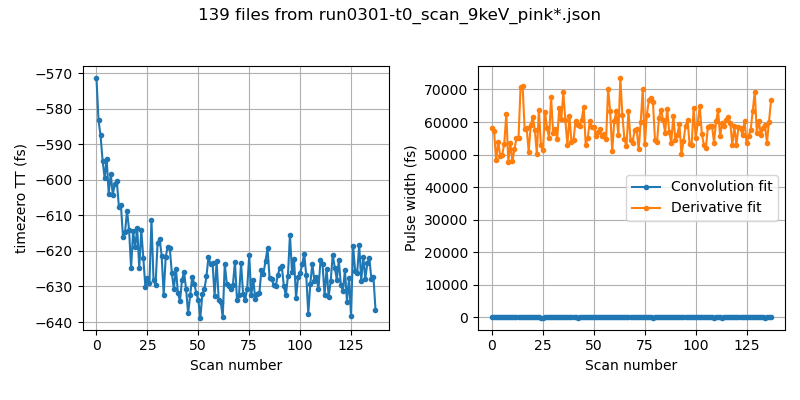

In [50]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
#plt.ylim(-100, 0)

plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.', label='Convolution fit')
plt.plot(width_fs_der, marker='.', label = 'Derivative fit')
plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

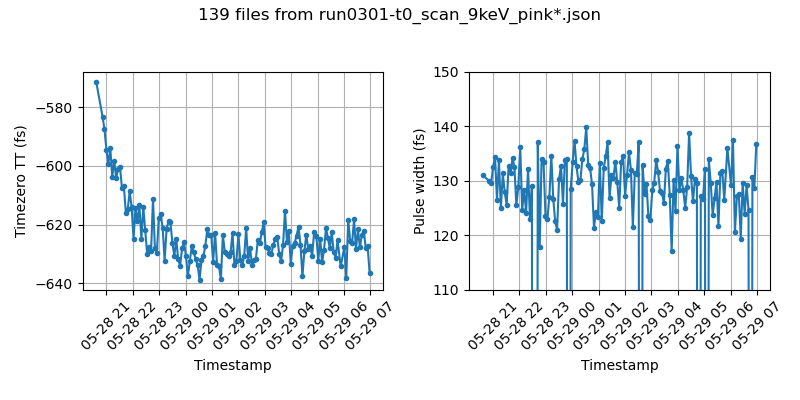

In [49]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
# plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(121)
plt.plot(timestamps_npy, t0_fs_scan, marker='.')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 45)
#plt.ylim(-75,-10)
plt.grid()

plt.subplot(122)
plt.plot(timestamps_npy, width_fs_scan, marker='.')
plt.xlabel('Timestamp')
plt.ylabel('Pulse width (fs)')
plt.xticks(rotation = 45)
plt.ylim(110,150)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

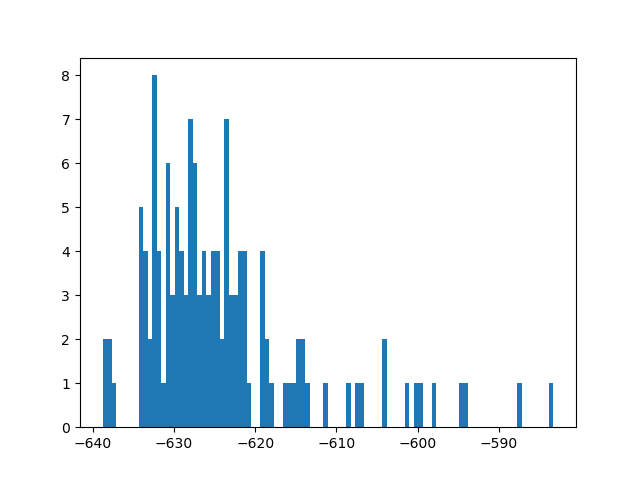

In [48]:
plt.figure()
plt.hist(t0_fs_scan[1:135], bins=100)
plt.show()

In [67]:
def fit_errorfunction(Delay_rebin, pp):
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    
    index = ~(np.isnan(Delay_rebin) | np.isnan(pp))
    Delay_rebin = Delay_rebin[index]
    pp =  pp[index]
    
    fit.estimate(Delay_rebin, pp)            # this sets some internal params 
    fit.fit(Delay_rebin,pp)                  # calculate the fit
    pp_fit = fit.eval(Delay_rebin)           # evaluate the curve for plotting
    
    t0 = fit.popt[0]
    width = np.abs(fit.popt[2])
    
    return t0, width

def fit_derivative(Delay_rebin, pp, p0=[0, 1, 50, 0]):
    
    index = ~(np.isnan(Delay_rebin) | np.isnan(pp))
    Delay_rebin = Delay_rebin[index]
    pp =  pp[index]
    
    ## gaussian(x, x0, amplitude, sigma, offset):
    pp_derivative = gaussian_filter1d(pp, 2, order = 1)
    params, _ = curve_fit(gaussian, Delay_rebin, pp_derivative, p0 = p0)
    
    t0 = params[0]
    width = np.abs(params[2]*2.355)
    
    return t0, width

In [130]:
TT1 = TT_PSEN124
TT2 = TT_PSEN126

quantile_band = 0.5
binsize = 5 # in fs

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820

flag = False

try:
    # Timezero_mm = get_timezero_NBS(fc.selected)
    Timezero_mm = get_timezero_NBS(patch[0])
    flag = True
except:
    Timezero_mm = Timezero_mm

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic
from tqdm import tqdm 

t0_fs_scan_124 =[]
width_fs_scan_124 = []
width_fs_der_124 = []
t0_fs_scan_126 =[]
width_fs_scan_126 = []
width_fs_der_126 = []

arrTimes_all_124 = []
arrTimes_all_126 = []

timestamps_npy = []
timestamps_hms = []
corr = []

for num, json_file in tqdm(enumerate(patch[:-1])):
#for num, json_file in enumerate(patch):
    print (json_file)
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    Delay_rbk, Pump_probe, \
    Delay_fs, Delays_corr1, arrtimes1, _, Pump_probe_scan, _, Delays_corr2, arrtimes2, _, _ = \
    YAG_scan_two_TT_bs(scan, TT1, TT2, channel_delay_motor, Timezero_mm, quantile_band)
    
    corr.append(pearsonr(arrtimes1, arrtimes2)[0])

    print (np.shape(Pump_probe_scan), np.shape(Delays_corr1), np.shape(Delays_corr2))
    
    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT1, binEdges, binNumber = binned_statistic(Delays_corr1, Pump_probe_scan, statistic='mean', bins=binList)
    pp_TT2, binEdges, binNumber = binned_statistic(Delays_corr2, Pump_probe_scan, statistic='mean', bins=binList)
    
    t0_fs_124, width_fs_124 = fit_errorfunction(Delay_fs_TT, pp_TT1)
    t0_fs_126, width_fs_126 = fit_errorfunction(Delay_fs_TT, pp_TT2)
    
    _, width_fs_124_d = fit_derivative(Delay_fs_TT, pp_TT1, p0=[-500, 1, 50, 0])
    _, width_fs_126_d = fit_derivative(Delay_fs_TT, pp_TT2, p0=[0, 1, 50, 0])
    
    t0_fs_scan_124.append(t0_fs_124)
    width_fs_scan_124.append(width_fs_124)
    width_fs_der_124.append(width_fs_124_d)
    t0_fs_scan_126.append(t0_fs_126)
    width_fs_scan_126.append(width_fs_126)
    width_fs_der_126.append(width_fs_126_d)
    
    timestamps_npy.append( timestamp(json_file) )
    timestamps_hms.append( timestamp_hms(json_file) )
    
    arrTimes_all_124.extend(arrtimes1)
    arrTimes_all_126.extend(arrtimes2)
    
print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))


Processing: run0300-t0_scan_9keV_pink_137
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                   501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative2       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position          501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw2              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background2 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projecti

138it [2:43:45, 71.20s/it]

------------------------------
Timezero found in file = 184.314920000045 mm


In [131]:
len(timestamps_npy)

138

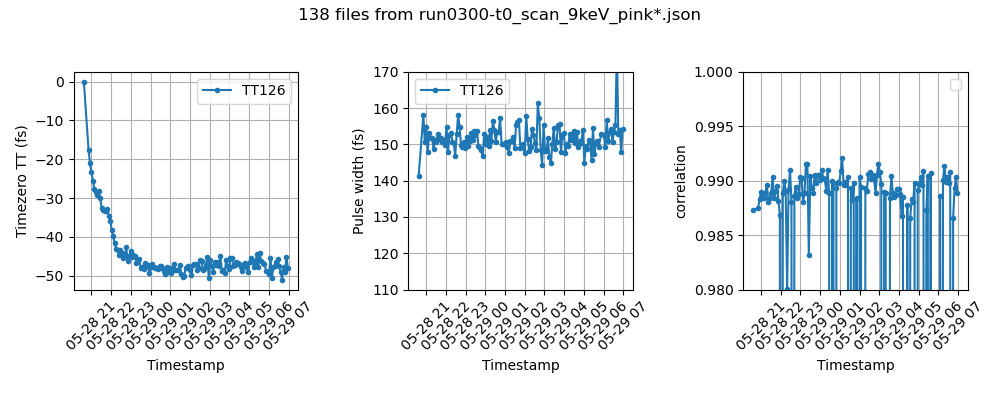

In [154]:
plt.figure(figsize = (10,4))
plt.suptitle ('{} files from {}'.format(len(patch[:-1]), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
# plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(131)
#plt.plot(timestamps_npy, t0_fs_scan_124-t0_fs_scan_124[0], marker='.', label='TT124')
plt.plot(timestamps_npy, t0_fs_scan_126-t0_fs_scan_126[0], marker='.', label='TT126')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 45)
plt.legend(loc='best')
#plt.ylim(-75,-10)
plt.grid()

plt.subplot(132)
#plt.plot(timestamps_npy, width_fs_scan_124, marker='.', label='TT124')
plt.plot(timestamps_npy, width_fs_scan_126, marker='.', label='TT126')
plt.xlabel('Timestamp')
plt.ylabel('Pulse width (fs)')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.ylim(110, 170)
plt.grid()

plt.subplot(133)
plt.plot(timestamps_npy, corr, marker='.')
plt.xlabel('Timestamp')
plt.ylabel('correlation')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.ylim(0.98, 1.0)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

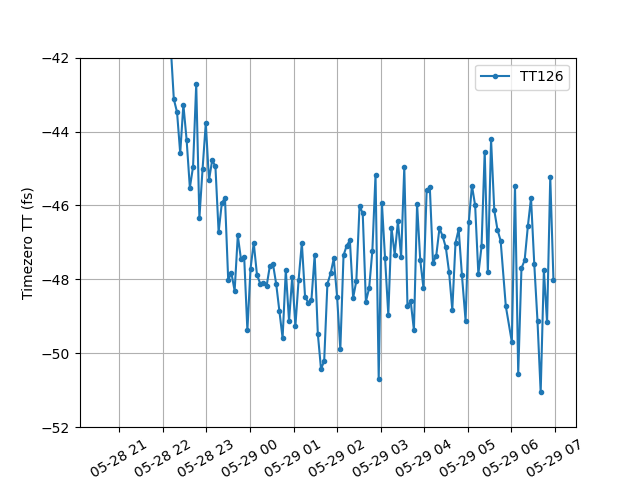

In [160]:
plt.figure()
plt.plot(timestamps_npy, t0_fs_scan_126-t0_fs_scan_126[0], marker='.', label='TT126')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 30)
plt.legend(loc='best')
plt.ylim(-52,-42)
plt.grid()

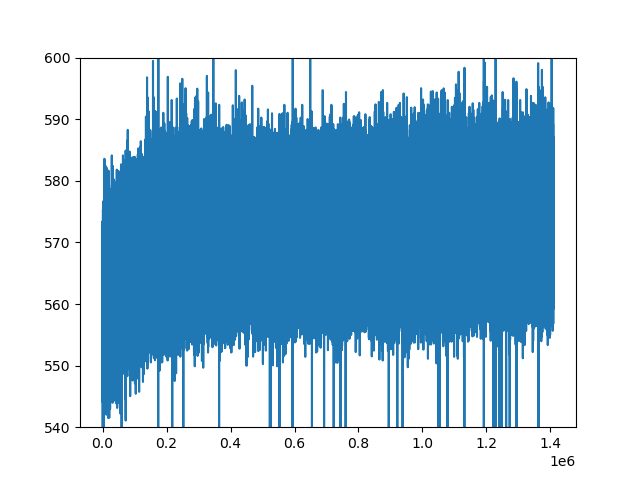

In [147]:
plt.figure()
plt.plot(np.array(np.array(arrTimes_all_126) - np.array(arrTimes_all_124)))
#plt.scatter(width_fs_scan_124, width_fs_scan_126)
plt.ylim(540, 600)
#plt.scatter(arrTimes_all_124, arrTimes_all_126)

plt.show()

In [112]:
np.shape(arrTimes_all_124)

(1409355,)

In [121]:
from scipy.stats.stats import pearsonr

arrTimes_124 = np.reshape(arrTimes_all_124[:1409000], (1000,1409))
arrTimes_126 = np.reshape(arrTimes_all_126[:1409000], (1000,1409))
corr = []
for ind in range(np.shape(arrTimes_124)[1]):
    corr.append(pearsonr(arrTimes_124[:,ind], arrTimes_126[:,ind])[0])

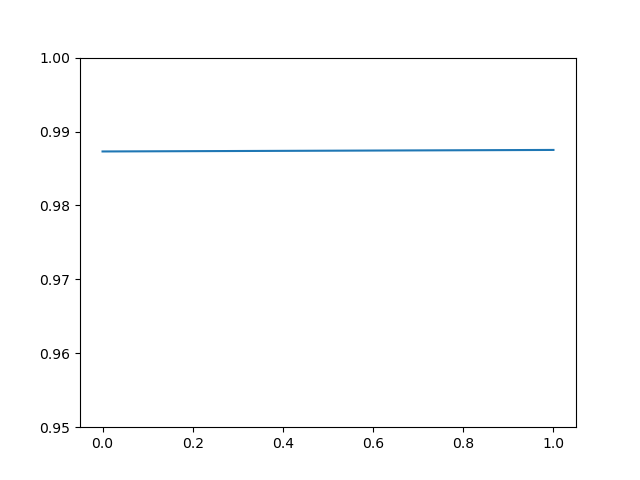

In [128]:
plt.figure()
plt.plot(corr)
plt.ylim(0.95,1)
plt.show()

## Extract timestamps separately

In [73]:
datafiles = []
for file in glob('/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles
patch

['/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_001.run0248/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_002.run0249/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_003.run0250/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_004.run0251/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_005.run0252/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_006.run0253/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_007.run0254/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_008.run0255/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_009.run0256/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_010.run0257/meta/scan.json',
 '/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_011.ru

In [76]:
from sfdata import SFScanInfo

timestamps_npy = []
timestamps_hms = []

for json_file in patch:
    clear_output(wait=True)
    print (json_file)
    scan = SFScanInfo(json_file)
      
    timestamps_npy.append( timestamp(json_file) )
    timestamps_hms.append( timestamp_hms(json_file) )

/sf/alvra/data/p19776/raw/catalog/YAG_timing_pink_vacuum_loop_189.run0436/meta/scan.json
